<a href="https://colab.research.google.com/github/pakeertana/workshop/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd

In [23]:
!pip install tensorflow keras

In [40]:
from ast import increment_lineno
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import matplotlib.image as mpimg

import plotly.offline as py
import plotly.express as px
import prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot

In [25]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pakeertana","key":"cfa578733bc000797c9c4895ae2ffdc4"}'}

In [26]:
import zipfile
os.makedirs("/root/.kaggle",exist_ok=True)

In [27]:
!mv kaggle.json /root/.kaggle

In [28]:
!chmod 600 /root/.kaggle/kaggle.json

In [29]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
!unzip chest-xray-pneumonia.zip -d chest_xray_data

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray_data/chest_xray/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ch

In [31]:
data='/content/chest_xray_data/chest_xray'

In [32]:
os.listdir(data)

['__MACOSX', 'test', 'train', 'val', 'chest_xray']

In [33]:
!rm -r /content/chest_xray_data/chest_xray/__MACOSX
!rm -r /content/chest_xray_data/chest_xray/chest_xray/test
!rm -r /content/chest_xray_data/chest_xray/chest_xray/train
!rm -r /content/chest_xray_data/chest_xray/chest_xray/val
!rm -r /content/chest_xray_data/chest_xray/chest_xray

In [34]:
data_dir="/content/chest_xray_data/chest_xray/train"

train_dataset=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(150,150),
    batch_size=16
)

Found 5216 files belonging to 2 classes.


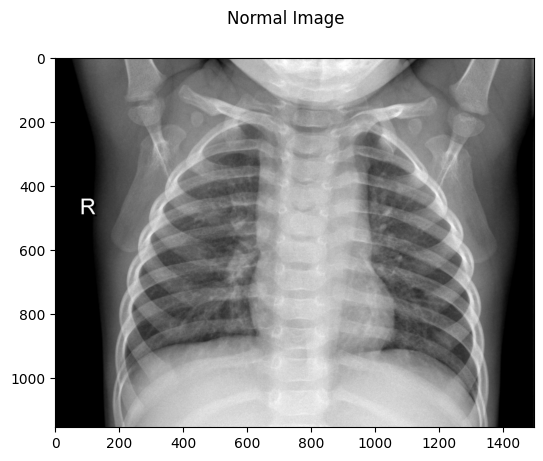

In [35]:
normal_images=[]
for img_path in glob.glob('/content/chest_xray_data/chest_xray/train/NORMAL/*'):
  normal_images.append(mpimg.imread(img_path))

fig=plt.figure()
fig.suptitle('Normal Image')
plt.imshow(normal_images[0], cmap='gray')

In [36]:
Image_Width=150
Image_Height=150
Channels=3
INPUT_SHAPE=(Image_Width,Image_Height,Channels)
NB_CLASS=2
EPOCHS=30
BATCH_SIZE=6

In [41]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE,
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Optional: model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Optional: model.add(Dropout(0.25))

model.add(Flatten())

# Fully Connected Layers
model.add(Dense(128, activation='relu',
                kernel_regularizer=regularizers.l2(0.001))) # Added L2 regularization
model.add(Dropout(0.7))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [42]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

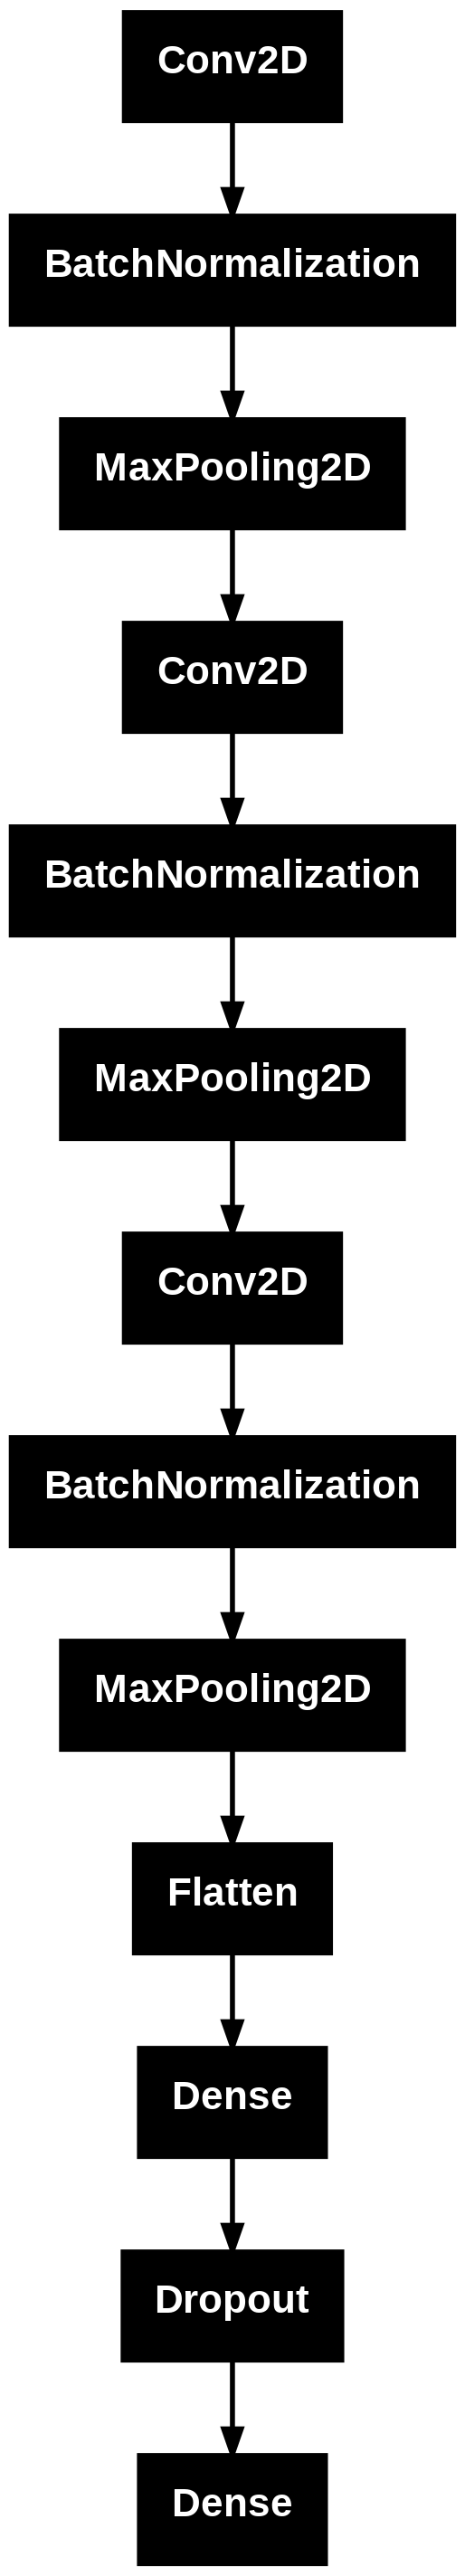

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png')

In [47]:
train_dir = "/content/chest_xray_data/chest_xray/train"
val_dir = "/content/chest_xray_data/chest_xray/val"
test_dir = "/content/chest_xray_data/chest_xray/test"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=16,
    label_mode='binary'  # use 'categorical' only if you want one-hot vectors
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(150, 150),
    batch_size=16,
    label_mode='binary'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=16,
    label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [50]:
train_files = 5216
val_files = 16
batch_size = 16

steps_per_epoch = train_files // batch_size
validation_steps = val_files // batch_size

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 43s 103ms/step - accuracy: 0.8570 - loss: 2.1813 - val_accuracy: 0.7500 - val_loss: 1.0089
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step - accuracy: 0.9152 - loss: 0.7580 - val_accuracy: 0.5625 - val_loss: 1.0663
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.9338 - loss: 0.6069 - val_accuracy: 0.7500 - val_loss: 1.1088
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.9283 - loss: 0.6346 - val_accuracy: 1.0000 - val_loss: 0.6158
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.9329 - loss: 0.5925 - val_accuracy: 0.9375 - val_loss: 0.6570
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accuracy: 0.9283 - loss: 0.6142 - val_accuracy: 0.7500 - val_loss: 1.2316
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - accuracy: 0.9535 - loss: 0.4703 - val_accuracy: 0.6250 - val_loss: 6.6275
Epoch 8/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.9390 - loss: 0.5529

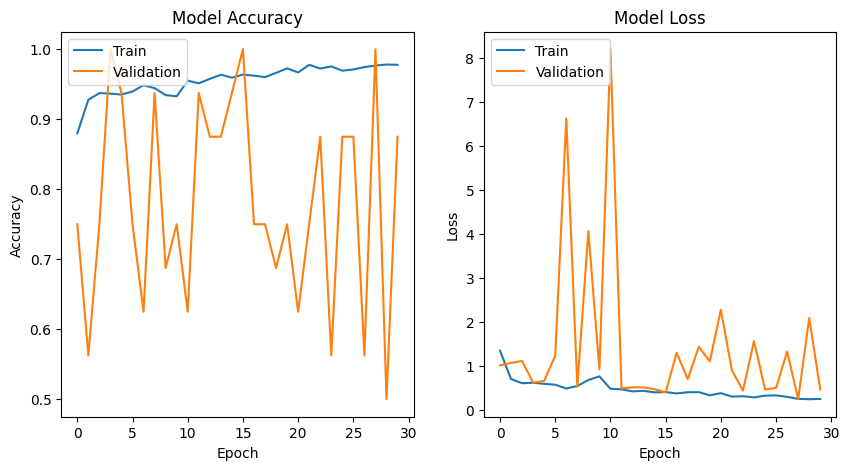

In [51]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train','Validation'],loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train','Validation'],loc='upper left')
plt.show()

In [52]:
print("training_accuracy",history.history['accuracy'][-1])
print("validation_accuracy",history.history['val_accuracy'][-1])

training_accuracy 0.9777607321739197
validation_accuracy 0.875


In [53]:
class_names=val_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [54]:
true_labels=[]
for images, labels in val_dataset:
  true_labels.extend(labels.numpy())
true_labels=np.array(true_labels)

In [57]:
predictions=model.predict(val_dataset)
#predicted_classes=np.argmax(predictions0,axis=1) #Only for softmax output
#OR if its binary classification with sigmoid output:
predicted_classes=(predictions>0.5).astype("int32").flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [59]:
predicted_labels=[class_names[i] for i in predicted_classes]
true_labels_names=[class_names[int(i)] for i in true_labels]

/tmp/ipython-input-1067088575.py:2: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [60]:
print(predicted_labels[:10])
print(true_labels_names[:10])

['PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA']
['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA']


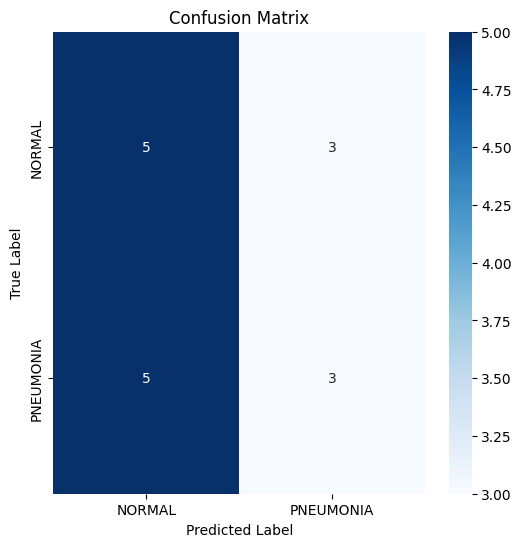

In [65]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,6))
cf=confusion_matrix(true_labels_names,predicted_labels)
sns.heatmap(cf,
            cmap="Blues",
            linecolor='black',
            annot=True,
            fmt='',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [61]:
pred_class=np.array(predicted_labels)

In [62]:
label_map={'NORMAL':0,'PNEUMONIA':1}
pred_class=np.array([label_map[label] for label in predicted_labels])
true_class=np.array([int(label) for label in true_labels])

/tmp/ipython-input-1666110985.py:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [64]:
correct=np.nonzero(pred_class==true_class)[0]
correct=np.nonzero(pred_class==true_class)[0]
accuracy=len(correct)/len(true_class)
print(f"accuracy from comparison:{accuracy:.4f}")

accuracy from comparison:0.5000


In [67]:
val_images=[]
val_labels=[]
for img, label in val_dataset.unbatch().take(100):
    val_images.append(img.numpy())
    val_labels.append(label.numpy())

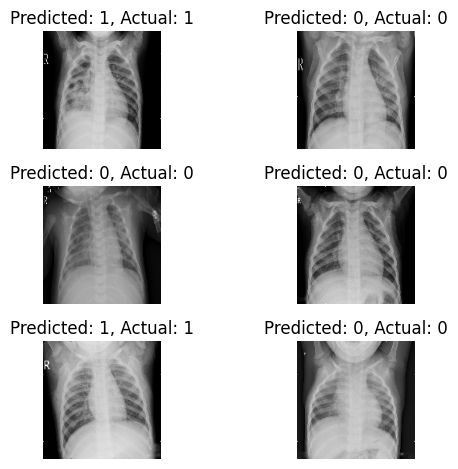

In [72]:
i=0
for c in correct[:6]:
  plt.subplot(3,2,i+1)
  plt.imshow(val_images[c].astype("uint8"))
  plt.title("Predicted: {}, Actual: {}".format(pred_class[c],true_class[c]))
  plt.axis('off')
  i+=1

plt.tight_layout()
plt.show()